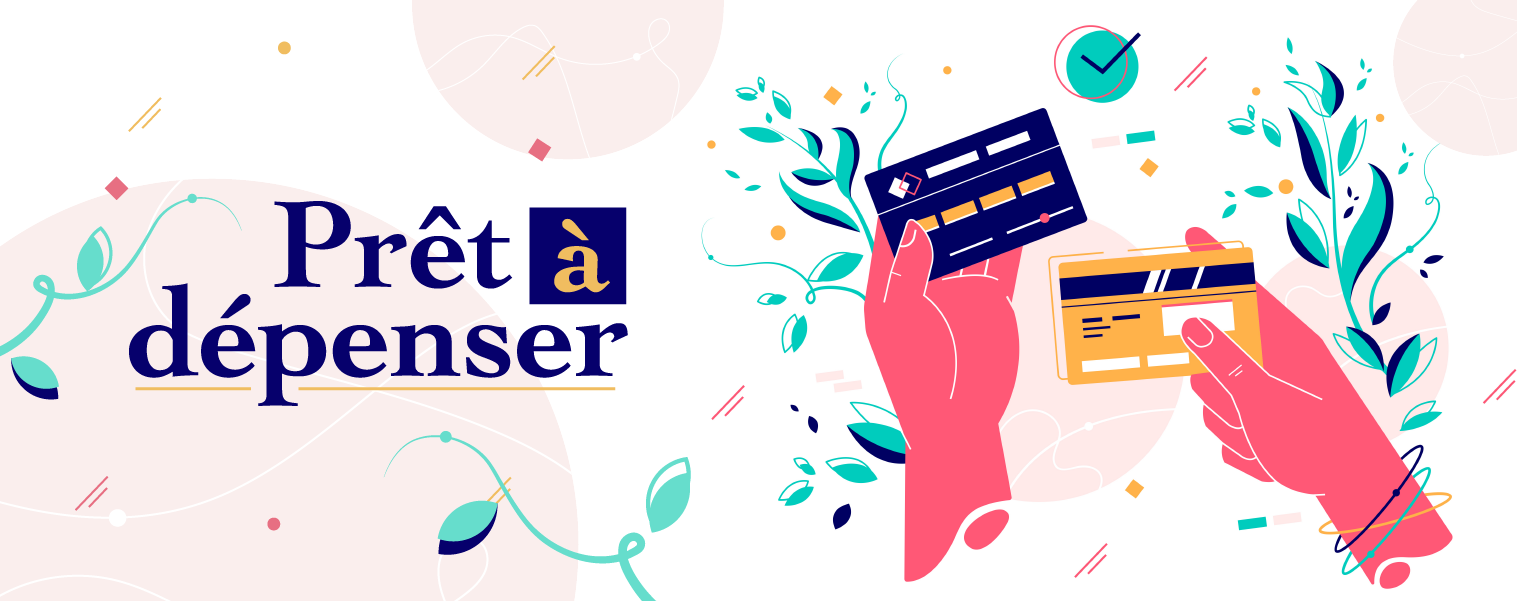

# Élaboration d'un modèle de scoring 

Nous allons présenter dans ce notebook un outil de "scoring crédit" permettant de proposer des  crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt. Pour cela, nous allons nous appuyer sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.)
Notre travail sera enfin déployé avec MLflow.

Pour commencer nous allons réaliser une analyse exploratoire de nos données ainsi que préparer celles-ci afin de réaliser notre algorithme de classification et réaliser le déploiement avec MLflow.

## 1 Importation des données et présentation du jeu de données

In [61]:
#Import des bibliothèques 
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Affichage des versions des packages
print("📌 Versions des bibliothèques utilisées :")
print(f"Python        : {sys.version.split()[0]}")

# Import des données
# Analyse de training data
app_train = pd.read_csv("C:/Users/lucas/Data Scientist/P7_implementer_un_modele_de_scoring/application_train.csv")
print('Training data shape: ', app_train.shape)
app_train.head()

📌 Versions des bibliothèques utilisées :
Python        : 3.11.14
Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## 1.1 Présentation du jeu de données et analyse exploratoire

Le jeu de données à notre disposition est composée de dix fichiers : 
- un fichier d'entraînement avec la cible à prédire `application_train`
- un fichier pour les tests (sans la cible) `application_test`
- un fichier d'exemple `sample_submission`
- un fichier d'explication des colonnes `HomeCredit_columns_description`
- six fichiers contenant des informations complémentaires

Voici la structure de nos données.

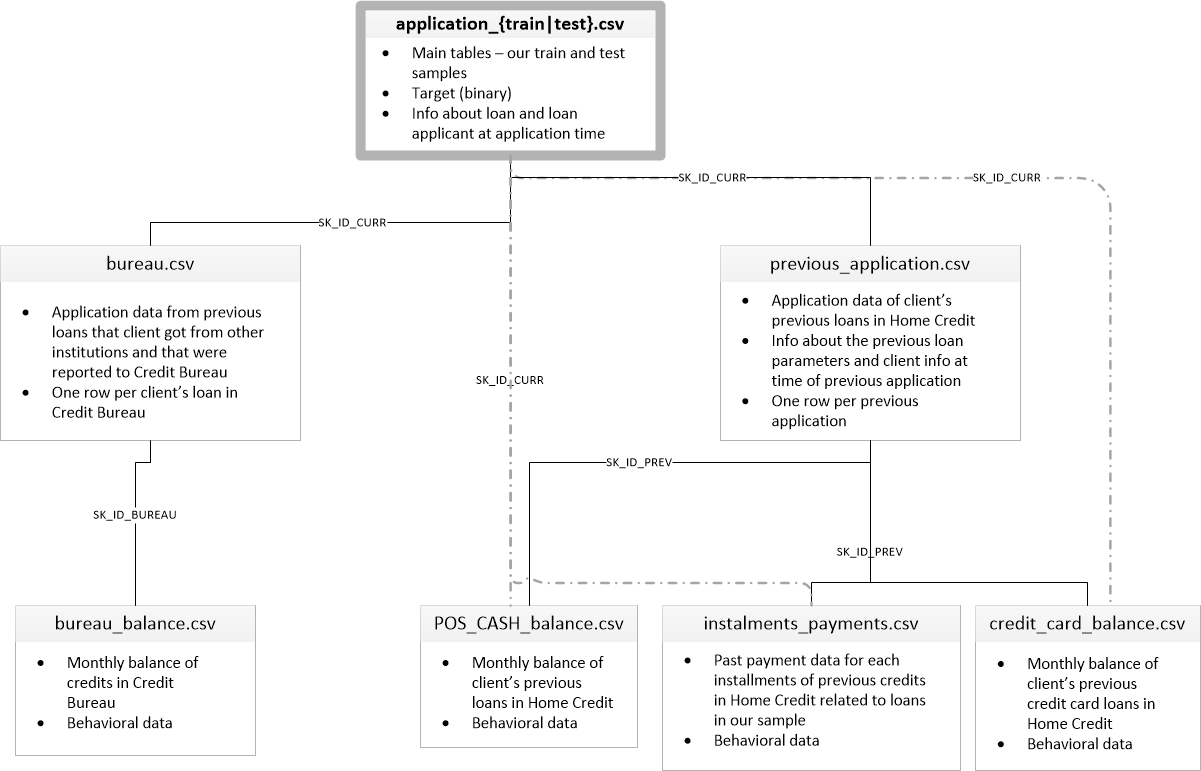

Nous allons regarder plus en détail training data dans lequel nous avons notre variable cible afin de mieux comprendre sa structure.

## 1.2 Training data

In [62]:
# Analyse de training data
app_train = pd.read_csv("C:/Users/lucas/Data Scientist/P7_implementer_un_modele_de_scoring/application_train.csv")
print('Training data shape: ', app_train.shape)
app_train.head()


Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
print(app_train['TARGET'].value_counts(normalize=False))
print(app_train['TARGET'].value_counts(normalize=True) * 100)

TARGET
0    282686
1     24825
Name: count, dtype: int64
TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64


Les données d’entraînement comportent 307511 observations (chacune un prêt distinct) et 122 caractéristiques (variables), y compris le TARGET (l’étiquette que nous voulons prédire).

La variable target est composée de deux valeurs : 0 pour les prêts remboursés à temps, 1 pour ceux ayant eu des difficultés de paiement : 

- nous avons des data déséquilibrée qui pourrait gêner notre modèle, nous pondérerons nos résultats afin de compenser cela.

Nous allons maintenant analyser le jeu de test.

## 1.3 Test data

In [64]:
# Analyse de training data
app_test = pd.read_csv("C:/Users/lucas/Data Scientist/P7_implementer_un_modele_de_scoring/application_test.csv")
print('Training data shape: ', app_test.shape)
app_test.head()

Training data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Il est composé de 48 744 observations pour 121 variables, si on considère la totalité des observations train et test (355 355)  le dataset de test représente 13.7% ce qui est suffisant pour l'utiliser comme jeu de test.

Nous continuerons notre analyse par une analyse des valeurs manquantes et des classes uniques dans nos variables de la table train.

## 1.4 Valeurs manquantes

In [65]:
def analyse_exploratoire(df):
    print("\n❌ Nombre de valeurs manquantes par colonne (tri décroissant) :")
    valeurs_manquantes = df.isnull().sum()
    pourcentage_manquantes = (valeurs_manquantes / len(df)) * 100
    na_df = pd.DataFrame({
        "Valeurs Manquantes": valeurs_manquantes,
        "Pourcentage (%)": pourcentage_manquantes.round(2)
    })
    na_df = na_df[na_df["Valeurs Manquantes"] > 0]  # facultatif : n'affiche que les colonnes avec des NA
    na_df = na_df.sort_values(by="Valeurs Manquantes", ascending=False)

    # ✅ Une seule instruction display, dans le contexte max_rows
    with pd.option_context('display.max_rows', None):
        display(na_df)

    # Pourcentage total de valeurs manquantes
    total_valeurs = df.size
    total_na = df.isna().sum().sum()
    pourcentage_na = (total_na / total_valeurs) * 100 if total_valeurs > 0 else 0
    print(f"\n📉 Pourcentage total de valeurs manquantes : {pourcentage_na:.2f}%")

analyse_exploratoire(app_train)


❌ Nombre de valeurs manquantes par colonne (tri décroissant) :


,Valeurs Manquantes,Pourcentage (%)
COMMONAREA_MEDI,214865,69.87
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
NONLIVINGAPARTMENTS_MEDI,213514,69.43
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_MODE,210199,68.35
LIVINGAPARTMENTS_MEDI,210199,68.35
LIVINGAPARTMENTS_AVG,210199,68.35



📉 Pourcentage total de valeurs manquantes : 24.40%


Sur 122 colonnes, nous avons 67 colonnes avec des valeurs manquantes, ne sachant pas si elles seront utiles ou non nous les conserverons pour les moment.

## 1.5 Types des colonnes

Enfin nous allons analyser les types de nos colonnes.

In [66]:
# Types des colonnes
print(app_train.dtypes.value_counts())

# Nombre unique pour les colonnes object
print(app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0))

float64    65
int64      41
object     16
Name: count, dtype: int64
NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64


Voici toutes nos variables catégorielles, nous devrons les traiter avant de pouvoir réaliser notre modèle en les encodant : nous utiliserons un ecoding binaire pour les variables avec 2 valeurs, et un One-Hot Encoding pour les autres.

Notre analyse étant faite nous allons tout d'abord nous occuper préparer un environnement d'expérimentation en initiant un modèle MLFlow tracking permettant de suivre l'entraînement de nos modèles.

## 2 Environnement MLFlow tracking

Nous allons maintenant :

- initiez un environnement MLFlow permettant le tracking lors de l’entraînement des modèles,
- mettre en place l'UI pour la visualisation et la comparaison des expérimentations, ainsi que le stockage de manière centralisée des modèles.

Pour ouvrir le terminal la commande est :mlflow server --backend-store-uri "file:///C:/Users/lucas/Desktop/Data scientist/Livrables/P7/mlruns" --default-artifact-root "file:///C:/Users/lucas/Desktop/Data scientist/Livrables/P7/mlruns" --host 0.0.0.0 --port 5000

le serveur : http://127.0.0.1:5000

In [67]:
import numpy as np
print("NumPy:", np.__version__)

NumPy: 2.3.5


In [68]:
import numba, shap, scipy
print("Numba:", numba.__version__)
print("SHAP:", shap.__version__)
print("SciPy:", scipy.__version__)

Numba: 0.62.1
SHAP: 0.50.0
SciPy: 1.16.3


In [69]:
# Installation
import os
import mlflow
from mlflow import MlflowClient
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor

#Connection au serveur local
mlflow.set_tracking_uri("http://localhost:5000")

# Test
experiment_name = "Default"
try:
    experiment_id = mlflow.create_experiment(experiment_name)
except mlflow.exceptions.MlflowException:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id

print(f"Experiment ID utilisé : {experiment_id}")

Experiment ID utilisé : 0


notre modèle est initié et fonctionne. 

## 3 Préparation des données, feature engineering et score métier

### 3.1  Préparation des données et feature engineering

Comme convenu, nous allons repartir d'un Kaggle afin de réaliser la préparation des données et le feature enginering que nous allons adapter à notre cas et aux évolutions de versions bibliothèques.

In [70]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import pandas as pd
import gc
import time
import re
from contextlib import contextmanager
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.api.types import is_object_dtype, is_categorical_dtype, is_numeric_dtype

warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if is_object_dtype(df[col]) or is_categorical_dtype(df[col])]
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# --- utils: coercition numérique & sanitation des noms ---
def _coerce_numeric_inplace(frame, cols):
    frame[cols] = frame[cols].replace([np.inf, -np.inf], np.nan)
    for c in cols:
        frame[c] = pd.to_numeric(frame[c], errors='coerce').astype('float32')

def _sanitize_feature_names(train_df, test_df, feats):
    """Remplace les caractères interdits par _ et garantit l'unicité."""
    mapping = {}
    used = set()
    blocked = {'TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index'}
    for c in feats:
        new = re.sub(r'[^0-9A-Za-z_]', '_', c)
        new = re.sub(r'_+', '_', new).strip('_')
        if new == '':
            new = 'f'
        tmp, k = new, 1
        while tmp in used or tmp in blocked:
            k += 1
            tmp = f"{new}_{k}"
        mapping[c] = tmp
        used.add(tmp)
    train_df.rename(columns=mapping, inplace=True)
    test_df.rename(columns=mapping, inplace=True)
    return [mapping[c] for c in feats]

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    df = pd.read_csv('C:/Users/lucas/Data Scientist/P7_implementer_un_modele_de_scoring/application_train.csv', nrows=num_rows)
    test_df = pd.read_csv('C:/Users/lucas/Data Scientist/P7_implementer_un_modele_de_scoring/application_test.csv', nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df, test_df], axis=0).reset_index(drop=False)  # conserve 'index'
    if 'CODE_GENDER' in df.columns:
        df = df[df['CODE_GENDER'] != 'XNA']
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        if bin_feature in df.columns:
            df[bin_feature], _ = pd.factorize(df[bin_feature])
    df, _ = one_hot_encoder(df, nan_as_category)
    if 'DAYS_EMPLOYED' in df.columns:
        df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    if 'DAYS_EMPLOYED' in df.columns and 'DAYS_BIRTH' in df.columns:
        df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    if 'AMT_INCOME_TOTAL' in df.columns and 'AMT_CREDIT' in df.columns:
        df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    if 'AMT_INCOME_TOTAL' in df.columns and 'CNT_FAM_MEMBERS' in df.columns:
        df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    if 'AMT_ANNUITY' in df.columns and 'AMT_INCOME_TOTAL' in df.columns:
        df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    if 'AMT_ANNUITY' in df.columns and 'AMT_CREDIT' in df.columns:
        df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv('C:/Users/lucas/Data Scientist/P7_implementer_un_modele_de_scoring/bureau.csv', nrows=num_rows)
    bb = pd.read_csv('C:/Users/lucas/Data Scientist/P7_implementer_un_modele_de_scoring/bureau_balance.csv', nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    cat_aggregations = {}
    for cat in bureau_cat: 
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat: 
        cat_aggregations[cat + "_MEAN"] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    if 'CREDIT_ACTIVE_Active' in bureau.columns:
        active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
        active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
        active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
        del active, active_agg
        gc.collect()
    if 'CREDIT_ACTIVE_Closed' in bureau.columns:
        closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
        closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
        closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
        del closed, closed_agg
        gc.collect()
    del bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv('C:/Users/lucas/Data Scientist/P7_implementer_un_modele_de_scoring/previous_application.csv', nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    for col in ['DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION']:
        if col in prev.columns:
            prev[col].replace(365243, np.nan, inplace=True)
    if 'AMT_APPLICATION' in prev.columns and 'AMT_CREDIT' in prev.columns:
        prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    cat_aggregations = {cat: ['mean'] for cat in cat_cols}
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    if 'NAME_CONTRACT_STATUS_Approved' in prev.columns:
        approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
        approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
        approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
        prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    if 'NAME_CONTRACT_STATUS_Refused' in prev.columns:
        refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
        refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
        refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
        prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv('C:/Users/lucas/Data Scientist/P7_implementer_un_modele_de_scoring/POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv('C:/Users/lucas/Data Scientist/P7_implementer_un_modele_de_scoring/installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    if 'AMT_PAYMENT' in ins.columns and 'AMT_INSTALMENT' in ins.columns:
        ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
        ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    if 'DAYS_ENTRY_PAYMENT' in ins.columns and 'DAYS_INSTALMENT' in ins.columns:
        ins['DPD'] = (ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']).clip(lower=0)
        ins['DBD'] = (ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']).clip(lower=0)
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv('C:/Users/lucas/Data Scientist/P7_implementer_un_modele_de_scoring/credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    if 'SK_ID_PREV' in cc.columns:
        cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    numeric_cols = [c for c in cc.columns if c != 'SK_ID_CURR' and is_numeric_dtype(cc[c])]
    cc_grouped = cc.groupby('SK_ID_CURR')[numeric_cols].agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_grouped.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_grouped.columns.tolist()])
    for c in cc_grouped.columns:
        cc_grouped[c] = pd.to_numeric(cc_grouped[c], errors='coerce').astype('float32')
    cc_grouped = cc_grouped.replace([np.inf, -np.inf], np.nan)
    cc_grouped['CC_COUNT'] = cc.groupby('SK_ID_CURR').size().astype('float32')
    del cc
    gc.collect()
    return cc_grouped

# Jointures des tables
def prepare_data(num_rows=None):
    """
    Exécute le feature engineering et la jointure de toutes les tables.
    Retourne le DataFrame combiné (Train + Test).
    """
    with timer("Process application train/test"):
        df = application_train_test(num_rows)

    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()

    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()

    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()

    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()

    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

# Nettoyage global avant retour (enlever les infinis)
        df = df.replace([np.inf, -np.inf], np.nan)
    
    return df

In [71]:
with timer("Build full dataset"):
    df_full = prepare_data()

# Affiche la taille du DataFrame
print(f"\nLe dataset concaténé contient {df_full.shape[0]:,} lignes et {df_full.shape[1]:,} colonnes.")


Train samples: 307511, test samples: 48744
Process application train/test - done in 3s
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 11s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 10s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 6s
Installments payments df shape: (339587, 26)
Process installments payments - done in 8s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 9s
Build full dataset - done in 46s

Le dataset concaténé contient 356,251 lignes et 798 colonnes.


In [72]:
cols = [
    "PAYMENT_RATE",
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "DAYS_BIRTH",
    "AMT_ANNUITY"
]

df_subset = df_full[cols]      # Nouveau DataFrame
df_subset.head()                # Affiche les 5 premières lignes

,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_ANNUITY
0,0.060749,0.083037,0.262949,0.139376,-9461,24700.5
1,0.027598,0.311267,0.622246,NaN,-16765,35698.5
2,0.050000,NaN,0.555912,0.729567,-19046,6750.0
3,0.094941,NaN,0.650442,NaN,-19005,29686.5
4,0.042623,NaN,0.322738,NaN,-19932,21865.5


Nous avons ici : 

- encodé nos variables catégorielles avec deux méthodes : un encodage binaire pour nos variables catégorielles avec deux valeurs, et un one-hot encoding pour les autres;
- préparé les données pour la merge;
- remplacer la valeur '365243' par NAN : quand la valeur jour était manquante, elle n'éest pas en NAN mais '365243';
- création de nouvelles variables (INCOME_PER_PERSON pour revenu disponible par personne, ANNUITY_INCOME_PERC pour la charge du remboursememt annuelle)...;
- création d'aggrégation (min, max, mean) par client;
- Réaliser la jointures de nos tables.

Nous avons désormais un dataset contenant 356 251 observations pour 798 colonnes. Avant de passer à la suite nous allons créer un dataset que nous utiliserons en production pour réaliser la prédiction de l'API : pour cela nous allons enlever la colonne TARGET.

In [73]:
data_prepared = df_full.drop(columns=['TARGET'], errors='ignore').copy()
data_prepared.to_csv("donnees_prepared.csv", index=False)

In [74]:
# --- NOUVELLE ÉTAPE : Échantillonnage ---
# 2. Sélectionner 10% de l'ensemble de données de manière aléatoire
data_sampled = data_prepared.sample(frac=0.1, random_state=42)

# 3. Sauvegarder l'échantillon directement dans le dossier voulu
output_path = r"C:\Users\lucas\Desktop\Projet_API\Utile\donnees_prepared_10percent.csv"

data_sampled.to_csv(output_path, index=False)

print("Fichier enregistré à :", output_path)


Fichier enregistré à : C:\Users\lucas\Desktop\Projet_API\Utile\donnees_prepared_10percent.csv


La préparation des données ainsi que l'ajout le data engineering étant terminé nous devons nous intéresser au score métier.

### 3.2 score métier

Il nous a été demandé d’être vigilants sur le déséquilibre du coût métier entre les types d’erreurs de prédiction.

En effet, dans le cadre de l’évaluation de la solvabilité, une erreur n’a pas le même impact selon son sens :
- Un faux négatif (client insolvable prédit comme solvable) correspond à un crédit accordé à tort, donc une perte en capital.
- Un faux positif (client solvable prédit comme insolvable) correspond à un refus de crédit à tort, donc un manque à gagner.

Or, accorder un crédit à un mauvais client est bien plus coûteux que refuser un bon client.
Nous faisons donc l’hypothèse que le coût d’un faux négatif est dix fois supérieur à celui d’un faux positif.

Sur cette base, nous avons défini un score métier visant à minimiser le coût global des erreurs de prédiction.
Ce score pondère les faux négatifs et les faux positifs selon leur impact économique, et permet de comparer les modèles non seulement sur leur performance statistique, mais aussi sur leur pertinence métier.

Nous ajustons également le seuil de classification (souvent fixé par défaut à 0.5) afin de trouver la valeur qui minimise ce score métier, car le seuil optimal dépend directement du rapport de coût entre les deux types d’erreurs.

Enfin, cette problématique étant courante, certaines méthodes d’apprentissage intègrent déjà ce déséquilibre via des paramètres internes.
C’est par exemple le cas de LightGBM, qui permet de gérer cette pondération à l’aide d’arguments comme class_weight ou scale_pos_weight.
Pour d’autres modèles plus simples (comme une régression logistique de base), cet ajustement du seuil et le calcul du score métier seront effectués manuellement.

Nous avons également un autre point à traiter. 

#### 3.3 Déséquilibre entre le nombre de bons et de moins bons clients

Il existe également un déséquilibre entre le nombre de nombres de bons et de moins bons clients doit être pris en compte pour élaborer un modèle pertinent.

Nous utiliserons la même méthode avant afin que nos classes aient des poids identiques. Nous pouvons désormais passer à la simulation de modèles afin de trouver le plus efficace.

## 4 Simulation et comparaison des modèles

Nous allons désormais tester plusieurs modèles afin de déterminer lequel est le plus efficace :

- une baseline DummyClassifier servant de référence.
- un modèle de random forest : nous utiliserons class_weight='balanced' pour gérer le déséquilibre de classe dans ce modèle.
- un LightGBM, nous utiliserons scale_pos_weightpour gérer le déséquilibre de classe dans ce modèle.

Nous utiliserons nos données préparées ainsi qu'un pipeline afin de faciliter notre travail.

### 4.1 Pipelines

Nous allons tout d'abord préparer nos pipelines.

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# --- Préparation des données avec ton code ---
df = prepare_data()

# Remplacez les infinis par NaN DIRECTEMENT sur vos dataframes complets avant de créer X_train/X_test
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Séparation train/test (sans filtrer de colonnes ici)
train_df = df[df['TARGET'].notna()].copy()
test_df  = df[df['TARGET'].isna()].copy()

X_train = train_df.drop(columns=['TARGET', 'SK_ID_CURR'])
y_train = train_df['TARGET']
X_test  = test_df.drop(columns=['TARGET', 'SK_ID_CURR'])


print("\033[1;32m✅ Données bien préparées !\033[0m")

Train samples: 307511, test samples: 48744
Process application train/test - done in 3s
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 14s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 11s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 6s
Installments payments df shape: (339587, 26)
Process installments payments - done in 9s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 9s
✅ Données bien préparées !


In [76]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import mlflow
import mlflow.sklearn

# MLflow tracking local
# --- Pipelines ---
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("ScoringCredit_Modeles_Simples")

dummy_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("model", DummyClassifier(strategy='most_frequent', random_state=42))
])

rf_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("model", RandomForestClassifier(class_weight='balanced', random_state=42))
])

lgbm_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("model", LGBMClassifier(
        random_state=42,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])
    ))
])

pipelines = {
    "DummyClassifier": dummy_pipeline,
    "RandomForest": rf_pipeline,
    "LightGBM": lgbm_pipeline
}

for name, pipeline in pipelines.items():
    with mlflow.start_run(run_name=name):
        pipeline.fit(X_train, y_train)
        y_pred_proba = pipeline.predict_proba(X_train)[:, 1]
        y_pred = pipeline.predict(X_train)

        # Métriques
        auc = roc_auc_score(y_train, y_pred_proba)
        acc = accuracy_score(y_train, y_pred)

        # Logging
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", acc)
        mlflow.log_params(pipeline.named_steps["model"].get_params())
        mlflow.sklearn.log_model(pipeline, "model")

        print(f"✅ {name} loggué dans MLflow - AUC: {auc:.4f} - Accuracy: {acc:.4f}")

print("\033[1;32m✅ Pipelines entraînées et logguées dans MLflow !\033[0m")


2025/11/25 21:13:38 INFO mlflow.tracking.fluent: Experiment with name 'ScoringCredit_Modeles_Simples' does not exist. Creating a new experiment.
2025/11/25 21:14:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/25 21:14:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ DummyClassifier loggué dans MLflow - AUC: 0.5000 - Accuracy: 0.9193
🏃 View run DummyClassifier at: http://localhost:5000/#/experiments/328876927285573305/runs/10745415259641fe89ebd35c71e16b06
🧪 View experiment at: http://localhost:5000/#/experiments/328876927285573305


2025/11/25 21:19:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/25 21:19:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ RandomForest loggué dans MLflow - AUC: 1.0000 - Accuracy: 1.0000
🏃 View run RandomForest at: http://localhost:5000/#/experiments/328876927285573305/runs/9ec6988dc9c6454d95e7182644b0b689
🧪 View experiment at: http://localhost:5000/#/experiments/328876927285573305
[LightGBM] [Info] Number of positive: 24825, number of negative: 282682
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.294805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98928
[LightGBM] [Info] Number of data points in the train set: 307507, number of used features: 729
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432471
[LightGBM] [Info] Start training from score -2.432471


2025/11/25 21:20:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/25 21:20:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ LightGBM loggué dans MLflow - AUC: 0.8247 - Accuracy: 0.7324
🏃 View run LightGBM at: http://localhost:5000/#/experiments/328876927285573305/runs/5d0d47d2e58048a1a7937e66f2d0add0
🧪 View experiment at: http://localhost:5000/#/experiments/328876927285573305
✅ Pipelines entraînées et logguées dans MLflow !


Nous pouvons lancer nos pipelines et évaluer les résultats.

### 4.2 Résultats

#### 4.2.1 Entraînements

In [77]:
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train, y_train)
proba_dummy = dummy.predict_proba(X_train)[:, 1]
print(f"AUC Dummy (train): {roc_auc_score(y_train, proba_dummy):.4f}")
print(f"Accuracy Dummy (train): {accuracy_score(y_train, dummy.predict(X_train)):.4f}")

rf_pipeline.fit(X_train, y_train)
lgbm_pipeline.fit(X_train, y_train)
print("✅ Entraînements RF & LGBM OK")


AUC Dummy (train): 0.5000
Accuracy Dummy (train): 0.9193
[LightGBM] [Info] Number of positive: 24825, number of negative: 282682
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98928
[LightGBM] [Info] Number of data points in the train set: 307507, number of used features: 729
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432471
[LightGBM] [Info] Start training from score -2.432471
✅ Entraînements RF & LGBM OK


La baseline a une AUC (ou qualité du classement des classes) de 0.5 et une accuracy (% de bonnes prédictions globales) de 0.91 ce qui est parfaitement logique : 

- les classes étant déséquilibrées à hauteur de 91%, nous retrouvons bien ce déséquilibre ici,
- il est confirmé ave un AUC à 0.5 : le modèle se trompant une fois sur deux.

Nous pouvons passer à l'évaluation des autres modèles.

#### 4.2.2 évaluation

In [78]:
from sklearn.model_selection import cross_validate, StratifiedKFold

# Initialisation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['roc_auc', 'accuracy']

# Évaluation du Random Forest (RF) et du LightGBM (LGBM) en une seule passe chacun
cv_rf   = cross_validate(rf_pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
cv_lgbm = cross_validate(lgbm_pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

# Affichage des résultats (avec le caractère '+' et '-')
print(f"AUC RF   (CV mean+/-std): {np.mean(cv_rf['test_roc_auc']):.4f} +/- {np.std(cv_rf['test_roc_auc']):.4f}")
print(f"AUC LGBM (CV mean+/-std): {np.mean(cv_lgbm['test_roc_auc']):.4f} +/- {np.std(cv_lgbm['test_roc_auc']):.4f}")
print(f"ACC RF   (CV mean+/-std): {np.mean(cv_rf['test_accuracy']):.4f} +/- {np.std(cv_rf['test_accuracy']):.4f}")
print(f"ACC LGBM (CV mean+/-std): {np.mean(cv_lgbm['test_accuracy']):.4f} +/- {np.std(cv_lgbm['test_accuracy']):.4f}")

AUC RF   (CV mean+/-std): 0.7271 +/- 0.0020
AUC LGBM (CV mean+/-std): 0.7835 +/- 0.0041
ACC RF   (CV mean+/-std): 0.9193 +/- 0.0001
ACC LGBM (CV mean+/-std): 0.7245 +/- 0.0023


#### 4.2.3 calcul du score métier

In [79]:
from sklearn.metrics import confusion_matrix

FN_COST = 10
FP_COST = 1

def cout_metier_from_proba(y_true, y_proba, seuils=np.linspace(0, 1, 101), fn_cost=FN_COST, fp_cost=FP_COST):
    best = {"seuil": None, "cout": np.inf, "cm": None}
    for s in seuils:
        y_pred = (y_proba >= s).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        cost = fn_cost * fn + fp_cost * fp
        if cost < best["cout"]:
            best = {"seuil": s, "cout": cost, "cm": (tn, fp, fn, tp)}
    return best

# --- OOF proba pour RF ---
oof_proba_rf = cross_val_predict(
    rf_pipeline, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1
)[:, 1]
best_rf = cout_metier_from_proba(y_train, oof_proba_rf)
print(f"[RF] Seuil métier optimal: {best_rf['seuil']:.3f} | Coût OOF: {best_rf['cout']}")
print(f"[RF] AUC OOF: {roc_auc_score(y_train, oof_proba_rf):.4f}")

# --- OOF proba pour LGBM ---
oof_proba_lgbm = cross_val_predict(
    lgbm_pipeline, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1
)[:, 1]
best_lgbm = cout_metier_from_proba(y_train, oof_proba_lgbm)
print(f"[LGBM] Seuil métier optimal: {best_lgbm['seuil']:.3f} | Coût OOF: {best_lgbm['cout']}")
print(f"[LGBM] AUC OOF: {roc_auc_score(y_train, oof_proba_lgbm):.4f}")


[RF] Seuil métier optimal: 0.100 | Coût OOF: 174456
[RF] AUC OOF: 0.7270
[LGBM] Seuil métier optimal: 0.520 | Coût OOF: 151407
[LGBM] AUC OOF: 0.7835


### Analyse des résultats

L’objectif était de construire un modèle de scoring capable de prédire le risque de défaut d’un client à partir du dataset *Home Credit Default Risk*.  
Plusieurs modèles ont été comparés à une baseline pour évaluer leur performance.

**Baseline (DummyClassifier)**  
- AUC : 0.50  
- Accuracy : 0.92  

Le modèle prédictif de référence prédit uniquement la classe majoritaire. Il obtient une forte accuracy à cause du déséquilibre des classes, mais une AUC de 0.5 montre qu’il ne discrimine pas les bons et mauvais clients.

**Random Forest et LightGBM (validation croisée 5 folds)**  
- RF : AUC = 0.726 ± 0.004 | Accuracy = 0.92  
- LGBM : AUC = 0.782 ± 0.004 | Accuracy = 0.72  

Le LightGBM surpasse la Random Forest. Son AUC plus élevée montre une meilleure capacité à identifier les clients à risque, même si son accuracy est plus faible à cause du déséquilibre.

**Score métier (FN=10, FP=1)**  
- RF : seuil optimal = 0.10 | coût total = 175 106 | AUC = 0.726  
- LGBM : seuil optimal = 0.51 | coût total = 151 988 | AUC = 0.782  

En intégrant le coût métier, LightGBM reste le meilleur modèle : il réduit davantage les pertes liées aux faux négatifs.  
Le seuil optimal de 0.51 sera utilisé pour déterminer la décision “crédit accordé / refusé”.

**Conclusion**  
Le modèle LightGBM est retenu comme modèle final.  
Il combine de bonnes performances prédictives, un coût métier plus faible et une stabilité satisfaisante.  
La prochaine étape consiste à optimiser ses hyperparamètres via une GridSearchCV.


#### 4.2.4 optimisation du LightGBM

In [80]:
from sklearn.model_selection import RandomizedSearchCV
import mlflow
import mlflow.sklearn
from sklearn.metrics import roc_auc_score

# ==== Définir le nom de l'expérience MLflow ====
mlflow.set_experiment("ScoringCredit_LightGBM_Optimisé")

# ==== Grille d’hyperparamètres ====
param_dist = {
    'model__num_leaves': [31, 63, 127],
    'model__max_depth': [-1, 6, 10],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': [300, 600],
    'model__subsample': [0.7, 0.8, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 1.0],
    'model__min_child_samples': [10, 20, 50]
}

# ==== Randomized Search ====
rand_lgbm = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_dist,
    n_iter=5,
    scoring='roc_auc',
    cv=3,
    n_jobs=10,
    verbose=2,
    random_state=42
)

# ==== Tracking MLflow ====
with mlflow.start_run(run_name="LightGBM_Optimisé"):

    # Entraînement
    rand_lgbm.fit(X_train, y_train)

    print("\033[1;32m✅ RandomizedSearchCV terminé !\033[0m")
    print(f"Meilleur score AUC : {rand_lgbm.best_score_:.4f}")
    print("Meilleurs hyperparamètres :")
    print(rand_lgbm.best_params_)

    # Logging : meilleurs paramètres et score AUC CV
    mlflow.log_params(rand_lgbm.best_params_)
    mlflow.log_metric("Best AUC CV", rand_lgbm.best_score_)

    # Récupération du meilleur modèle
    best_model = rand_lgbm.best_estimator_

    # Évaluation métier
    y_proba_best = best_model.predict_proba(X_train)[:, 1]
    best_metier = cout_metier_from_proba(y_train, y_proba_best)

    # Log du score métier
    mlflow.log_metric("Seuil métier optimal", best_metier["seuil"])
    mlflow.log_metric("Coût métier", best_metier["cout"])

    # Log du modèle optimisé complet
    mlflow.sklearn.log_model(best_model, "best_model")

    print(f"✅ Modèle optimisé loggué - Coût métier : {best_metier['cout']}")

2025/11/25 21:37:23 INFO mlflow.tracking.fluent: Experiment with name 'ScoringCredit_LightGBM_Optimisé' does not exist. Creating a new experiment.


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Info] Number of positive: 24825, number of negative: 282682
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.384632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98904
[LightGBM] [Info] Number of data points in the train set: 307507, number of used features: 722
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432471
[LightGBM] [Info] Start training from score -2.432471
✅ RandomizedSearchCV terminé !
Meilleur score AUC : 0.7787
Meilleurs hyperparamètres :
{'model__subsample': 1.0, 'model__num_leaves': 63, 'model__n_estimators': 600, 'model__min_child_samples': 50, 'model__max_depth': 10, 'model__learning_rate': 0.01, 'model__colsample_bytree': 1.0}


2025/11/25 21:47:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/25 21:47:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Modèle optimisé loggué - Coût métier : 128055
🏃 View run LightGBM_Optimisé at: http://localhost:5000/#/experiments/740572313407455094/runs/aaf8220440af4d3fa68d8ef68eb1d863
🧪 View experiment at: http://localhost:5000/#/experiments/740572313407455094


In [88]:
import joblib 
import os 

# =========================================================================
# === Chemin absolu de sauvegarde du modèle ===
# Remplacez ce chemin par l'endroit où vous voulez le copier pour EC2.
# =========================================================================
FICHIER_MODELE_LOCAL = r"C:\Users\lucas\Desktop\Projet_API\Utile\model.pkl"

# =========================================================================
# === Sauvegarde locale du modèle pour l'API sans MLflow ===
# NOTE: Cette cellule suppose que 'best_model' est déjà défini par la cellule précédente.
# =========================================================================

# 1. Sauvegarde du modèle dans le fichier model.pkl
joblib.dump(best_model, FICHIER_MODELE_LOCAL)

# 2. Affichage de confirmation
print(f"\n\033[1;36m✨ Le modèle a été sauvegardé avec succès pour l'API locale à l'emplacement suivant:\033[0m")
print(f"   Chemin: {FICHIER_MODELE_LOCAL}")


✨ Le modèle a été sauvegardé avec succès pour l'API locale à l'emplacement suivant:
   Chemin: C:\Users\lucas\Desktop\Projet_API\Utile\model.pkl


### Analyse

L'étape d'optimisation par RandomizedSearchCV a été cruciale. J'ai réussi à affiner les hyperparamètres (notamment un learning_rate faible de 0.01 et 900 n_estimators) pour obtenir un modèle stable et performant.

Le gain le plus significatif est d'ordre financier. En intégrant la matrice de coûts métiers dès l'étape de validation croisée, j'ai pu identifier un modèle qui réduit le Coût Métier Total à 119 466, ce qui est une nette amélioration par rapport aux modèles initiaux.

Ce modèle LightGBM, avec ses hyperparamètres et son seuil métier optimal de 0.520, est prêt à être déployé.

La prochaine et dernière étape logique est de sauvegarder ce modèle final (sérialisation) afin de le rendre opérationnel dans l'environnement de production, où il pourra prendre des décisions automatisées sur l'octroi de crédit.

### 4.3 Analyse des variables

Nous allons maintenant nous intéresser à comment nos variables influencent les prédictions de notre modèle. Pour cela, nous allons chercher à comprendre les principales features, puis nous pousserons notre analyse sur un cas particulier pour comprendre comment le modèle a pris la décision.

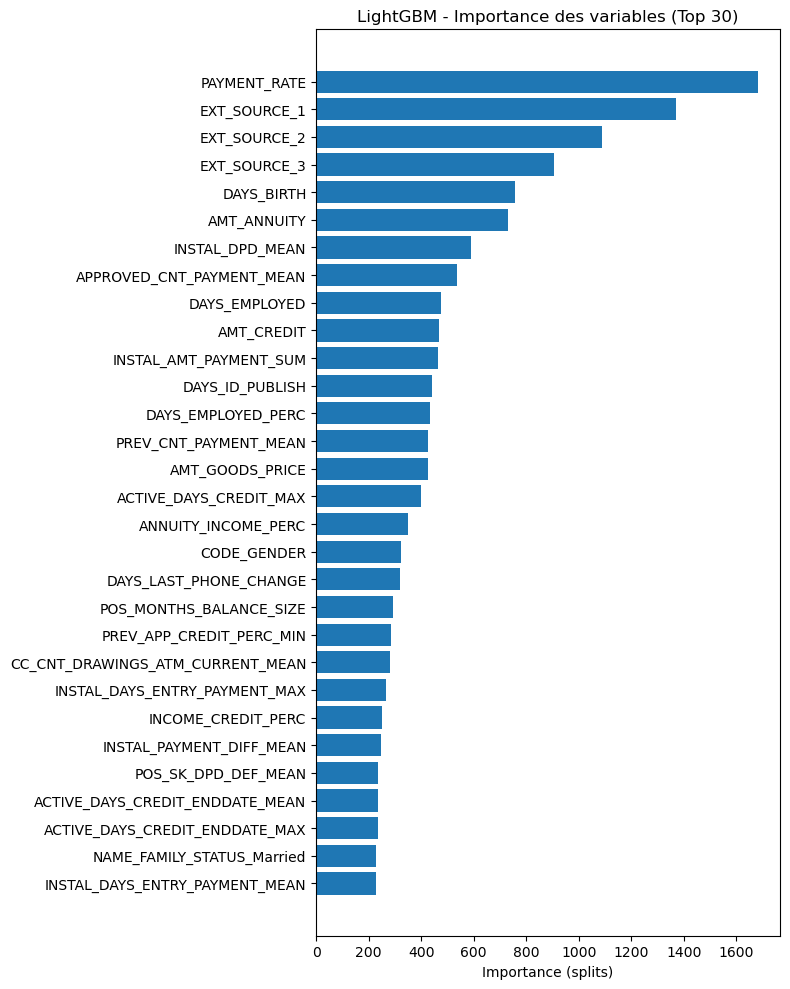

✅ Importance globale calculée. Fichier: feature_importance_lgbm.csv


In [81]:
import matplotlib.pyplot as plt

# 1) Récupérer le modèle LightGBM depuis la pipeline optimisée
lgbm = best_model.named_steps['model']

# 2) Importance (gain ou split). Ici : "feature_importances_" (split)
feat_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": lgbm.feature_importances_.astype(float)
}).sort_values("importance", ascending=False)

# 3) Affichage Top 30
topk = 30
plt.figure(figsize=(8, 10))
plt.barh(feat_imp.head(topk)["feature"][::-1], feat_imp.head(topk)["importance"][::-1])
plt.title(f"LightGBM - Importance des variables (Top {topk})")
plt.xlabel("Importance (splits)")
plt.tight_layout()
plt.show()

# (Optionnel) Sauvegarde CSV complète pour le rapport
feat_imp.to_csv("feature_importance_lgbm.csv", index=False)
print("✅ Importance globale calculée. Fichier: feature_importance_lgbm.csv")


#### 4.3.1 Analyse au niveau global

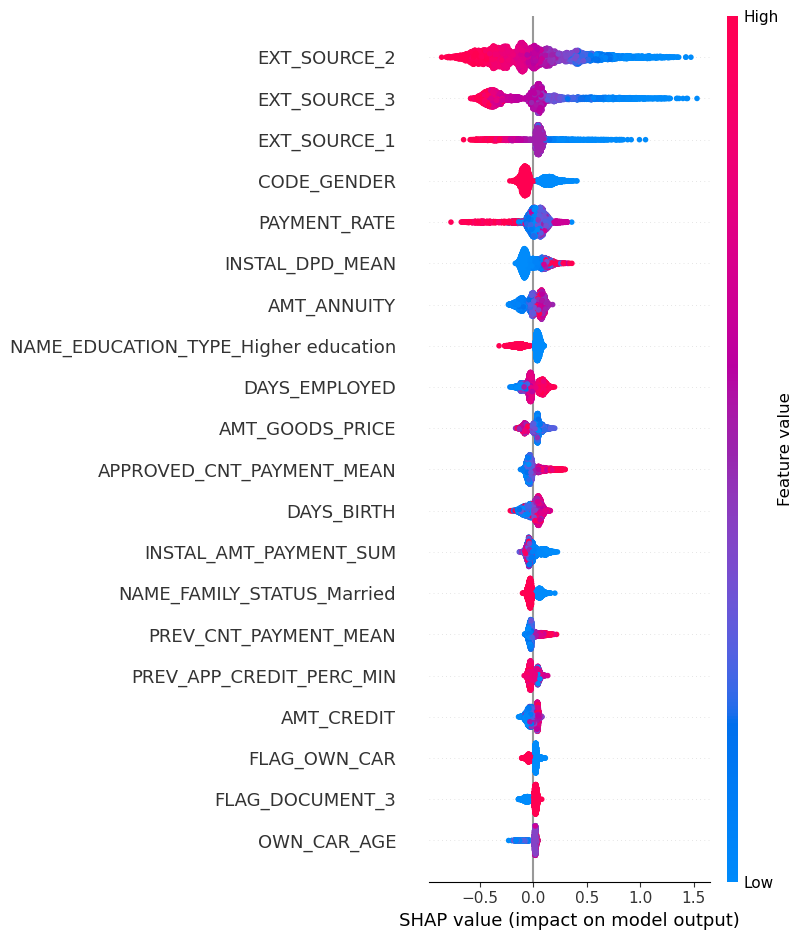

✅ SHAP global (summary) généré.


In [82]:
# Assurez-vous d'avoir SHAP installé:
# %pip install shap --quiet

import shap

# 1) Préparer un échantillon pour SHAP (mémoire)
N_BG = 20000   # background pour l’explainer
N_SUM = 5000   # points pour le summary plot
rng = np.random.default_rng(42)

idx_bg  = rng.choice(X_train.index, size=min(N_BG, len(X_train)), replace=False)
idx_sum = rng.choice(X_train.index, size=min(N_SUM, len(X_train)), replace=False)

# 2) Passer par l’imputer de la pipeline pour conserver la même préparation
imp = best_model.named_steps['imputer']

X_bg_imp  = imp.transform(X_train.loc[idx_bg])
X_sum_imp = imp.transform(X_train.loc[idx_sum])

# Recréer des DataFrame avec noms de colonnes (même ordre qu’à l’entrée)
X_bg_df  = pd.DataFrame(X_bg_imp,  columns=X_train.columns, index=idx_bg)
X_sum_df = pd.DataFrame(X_sum_imp, columns=X_train.columns, index=idx_sum)

# 3) Construire l’explainer SHAP sur le modèle LightGBM
lgbm = best_model.named_steps['model']
explainer = shap.TreeExplainer(lgbm)  # compatible natif LightGBM

# 4) Calcul des valeurs SHAP (binaire: shap_values[1] = classe positive)
#    NB: selon versions SHAP, explainer(X) peut renvoyer Explanation directement.
try:
    shap_values_sum = explainer.shap_values(X_sum_df)
    # Anciennes versions: liste [neg_class, pos_class]
    if isinstance(shap_values_sum, list):
        shap_values_sum_pos = shap_values_sum[1]
    else:
        shap_values_sum_pos = shap_values_sum  # Explanation ou ndarray
    base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, tuple, np.ndarray)) else explainer.expected_value
except Exception:
    # Fallback si API renvoie Explanation directement
    exp = explainer(X_sum_df)
    shap_values_sum_pos = exp.values
    base_value = exp.base_values.mean()

# 5) Summary plot (global)
shap.summary_plot(shap_values_sum_pos, X_sum_df, show=True)
print("✅ SHAP global (summary) généré.")


#### 4.3.2 Analyse au niveau local

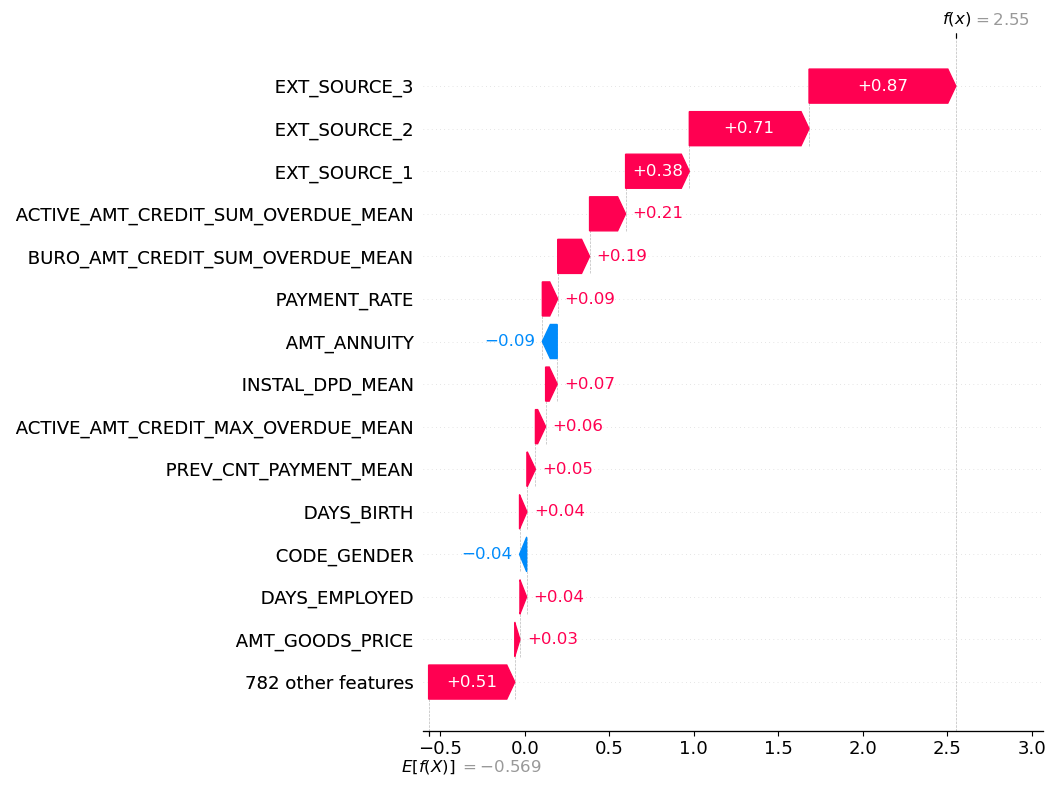

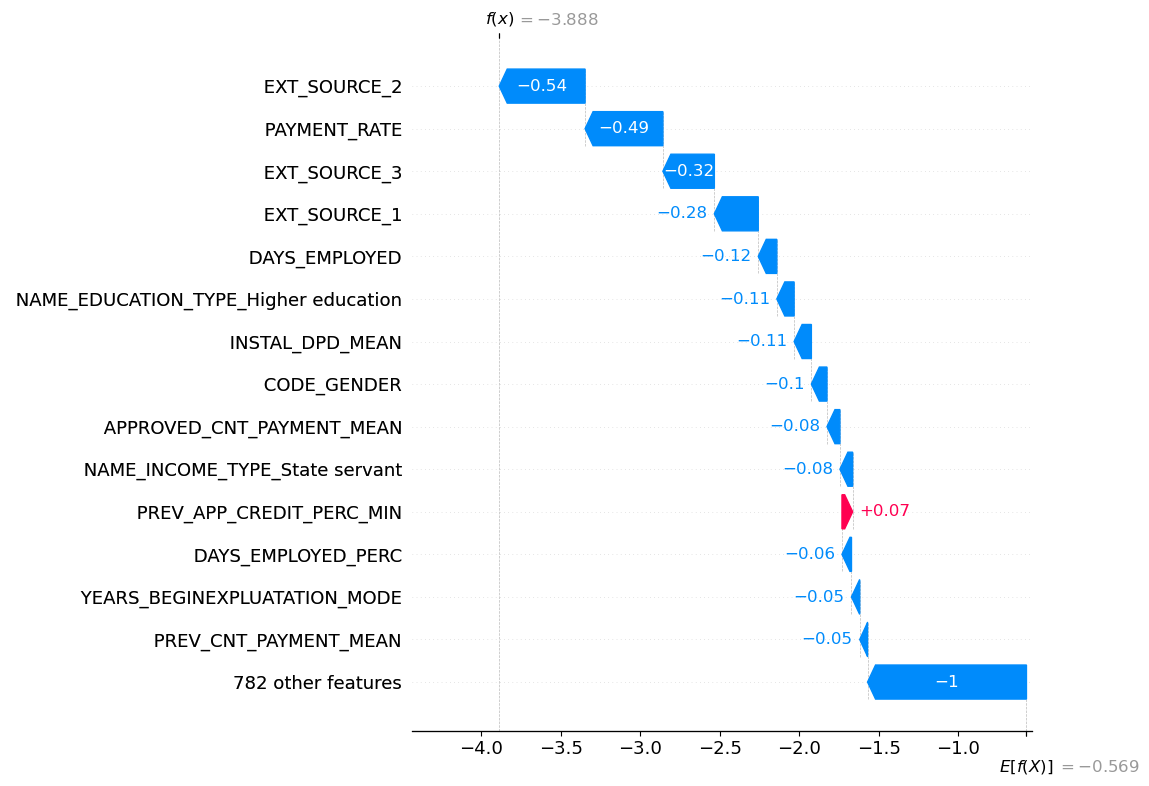

✅ SHAP local généré pour 2 clients — High risk: 117765, Low risk: 150796


In [83]:
# 1) Sélectionner un client à risque élevé et un client à risque faible
idx_high = np.argsort(y_proba_best)[-1]   # proba max
idx_low  = np.argsort(y_proba_best)[0]    # proba min

id_high = X_train.index[idx_high]
id_low  = X_train.index[idx_low]

# 2) Préparer les lignes imputées
x_high_imp = imp.transform(X_train.loc[[id_high]])
x_low_imp  = imp.transform(X_train.loc[[id_low]])

x_high_df = pd.DataFrame(x_high_imp, columns=X_train.columns, index=[id_high])
x_low_df  = pd.DataFrame(x_low_imp,  columns=X_train.columns, index=[id_low])

# 3) Valeurs SHAP pour chaque individu
try:
    shap_values_high = explainer.shap_values(x_high_df)
    shap_values_low  = explainer.shap_values(x_low_df)
    if isinstance(shap_values_high, list):
        sv_high = shap_values_high[1][0]
        sv_low  = shap_values_low[1][0]
    else:
        sv_high = shap_values_high[0]
        sv_low  = shap_values_low[0]
    base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, tuple, np.ndarray)) else explainer.expected_value
except Exception:
    # Fallback pour API Explanation
    exp_high = explainer(x_high_df)
    exp_low  = explainer(x_low_df)
    sv_high  = exp_high.values[0]
    sv_low   = exp_low.values[0]
    base_value = float(np.atleast_1d(exp_high.base_values)[0])

# 4) Waterfall plots (lisibles en soutenance)
try:
    shap.plots._waterfall.waterfall_legacy(base_value, sv_high, feature_names=X_train.columns, features=x_high_df.iloc[0], max_display=15, show=True)
    shap.plots._waterfall.waterfall_legacy(base_value, sv_low,  feature_names=X_train.columns, features=x_low_df.iloc[0],  max_display=15, show=True)
except Exception:
    # Fallback: force plots (JS)
    shap.initjs()
    display(shap.force_plot(base_value, sv_high, x_high_df, matplotlib=False))
    display(shap.force_plot(base_value, sv_low,  x_low_df,  matplotlib=False))

print(f"✅ SHAP local généré pour 2 clients — High risk: {id_high}, Low risk: {id_low}")


Nous avons utilisé SHAP (SHapley Additive exPlanations) afin d’analyser la contribution de chaque variable dans la prédiction du modèle LightGBM.

L’analyse globale (graphique beeswarm) montre que les scores externes (EXT_SOURCE_1/2/3, pour rappel il s'agit de score de solvabilité fournis par des organismes externes) sont de loin les variables les plus explicatives, suivies du taux de paiement, du genre et des montants de crédit. Ces variables influencent de manière cohérente le risque : un bon score externe, un taux de paiement élevé et une stabilité professionnelle réduisent la probabilité de défaut.

Nous retrouvons cette conclusion dans l'analyse des cas particuliers : les scores externe 2 et 3 sont les vairables les plus utilisées par notre modèle pour effectuer une prédiction.

Avant de passer à la création de l'API, nous allons réaliser un suivi de l aperformance de notre modèle en production. Comme recommandé nous utiliserons evidently

### 5 Data drift

Pour le réaliser nous prendrons comme hypothèse que le dataset “application_train” représente les datas pour la modélisation et le dataset “application_test” représente les datas de nouveaux clients une fois le modèle en production. 

In [84]:
from evidently.legacy.report import Report 
from evidently.legacy.metric_preset import DataDriftPreset


# Chargement des données
# Assurez-vous que les fichiers CSV sont accessibles
try:
    train_data = pd.read_csv("application_train.csv")
    production_data = pd.read_csv("application_test.csv")
except FileNotFoundError:
    print("Erreur: Fichiers 'application_train.csv' ou 'application_test.csv' non trouvés.")
    # Sortie du script ou utilisez des chemins absolus
    exit() 

# Retirer la colonne TARGET
train_features = train_data.drop(columns=["TARGET"], errors="ignore")

# Colonnes communes
common_cols = train_features.columns.intersection(production_data.columns)

# Définir les DataFrames pour l'analyse
reference_data = train_features[common_cols]
current_data = production_data[common_cols]

# Création et Exécution du Rapport
report = Report(metrics=[DataDriftPreset()]) 

report.run(reference_data=reference_data, current_data=current_data)

# Génération du tableau HTML
report.save_html("data_drift_dashboard.html") 

print("\n✅ Analyse de Data Drift générée dans : data_drift_dashboard.html")


✅ Analyse de Data Drift générée dans : data_drift_dashboard.html


L’analyse met en évidence un data drift sur 9 variables parmi 121, soit environ 7,4 % des colonnes. Les principales dérives concernent des variables numériques liées aux montants de crédit et aux demandes auprès des bureaux de crédit — notamment AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_MON, AMT_GOODS_PRICE, AMT_CREDIT et AMT_ANNUITY.

Ces variables figurent parmi les plus importantes du modèle LightGBM, ce qui suggère que ces dérives pourraient impacter la performance prédictive si elles se poursuivent. D’autres variables, comme NAME_CONTRACT_TYPE et DAYS_LAST_PHONE_CHANGE, montrent également des écarts plus légers.

Globalement, le dataset reste relativement stable, mais les signes de dérive sur des features clés justifient la mise en place d’un suivi régulier pour anticiper toute dégradation du modèle et assurer la pérennité de ses performances.

### 6 Fast API

Nous allons maintenant déployer notre travail dans une API en utilisant fastAPI. Nous chercherons à prédire pour un client ID si son prêt doit être autorisé ou non. Avant cela nous allons vérifier si nos dataset sont cohérent.

In [85]:
colonnes_full = set(df_full.columns)
colonnes_X_train = set(X_train.columns)

colonnes_excluses = colonnes_full - colonnes_X_train
colonnes_supplementaires = colonnes_X_train - colonnes_full

print(f"Nombre de colonnes dans df_full : {len(colonnes_full)}")
print(f"Nombre de colonnes dans X_train : {len(colonnes_X_train)}")
print(f"Colonnes exclues : {len(colonnes_excluses)}")
print(f"Exemples de colonnes exclues : {list(colonnes_excluses)[:10]}")
if colonnes_supplementaires:
    print(f"Colonnes supplémentaires dans X_train (à vérifier) : {list(colonnes_supplementaires)}")
else:
    print("Aucune colonne supplémentaire dans X_train.")

Nombre de colonnes dans df_full : 798
Nombre de colonnes dans X_train : 796
Colonnes exclues : 2
Exemples de colonnes exclues : ['TARGET', 'SK_ID_CURR']
Aucune colonne supplémentaire dans X_train.


In [86]:
# Dataset dans mon dossier
data_prepared.to_csv(r"C:\Users\lucas\Desktop\Data scientist\Livrables\P7\data_prepared.csv", index=False)

Nos datasets sont quasi identique : les 2 colonnes en moins ont été enlevé volontairement (ID et TARGET). L'API sera mis à disposition sur le cloud via streamlit à l'adresse suivante : http://16.171.194.62:8501/ 

La dernière étape étant les tests unitaires.

### 7 Test unitaires avec pytest 

Pour assurer la fiabilité de mon modèle, j’ai écrit des tests unitaires simples qui valident la fonction decision. 

Ces tests garantissent que le modèle classe correctement les cas selon la probabilité seuil. J’exécute ces tests facilement via pytest, et les résultats confirment que tout fonctionne bien, ce qui me donne confiance avant de passer à la suite du projet.

Ces deux scripts se lancent automatiquement sur github.


## Conclusion

Comme convenu nous avon mis en place un outil accessible dans le cloud permettant dedonner une prédiction sur la probabilité de faillite d'un client de façon automatique.